# Phase 5D.3: Operational Window Forecasting

**Objective**: Predict N-day weather windows using historical patterns and copula-enhanced probability.

**Building on Phase 5D1 & 5D2:**
- Phase 5D1: "When can I work?" (Single-hour & continuous window probabilities)
- Phase 5D2: "When am I safe?" (Extreme event risk during projects)
- **Phase 5D3: "When should I schedule?" (Optimal window identification + forecasting)**

**Key Questions:**
1. Given "I need 5 consecutive workable days", which month/week offers the best probability?
2. What's the expected waiting time between N-day weather windows?
3. How persistent are weather windows? (If Day 1 is workable, what's P(Day 2 workable)?)
4. Can we identify "safe windows" (workable + low extreme risk)?

**Methods:**
- Historical window identification (actual 5-day workable periods)
- Transition probability matrices (weather persistence)
- Combined scoring (workability + extreme risk from 5D1 & 5D2)
- Monte Carlo forecasting using copulas

---

## PART 1: SETUP & LOAD DATA

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import timedelta
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (18, 12)

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Cell 2: Load All Phase 5D Results

print("="*80)
print("LOADING PHASE 5D1, 5D2 RESULTS & HOURLY DATA")
print("="*80)

# Load hourly data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['week'] = df.index.isocalendar().week

print(f"✓ Loaded {len(df):,} hourly records")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

# Load Phase 5D1 results (weather window probabilities)
with open('../data/processed/phase5d1/weather_window_results.pkl', 'rb') as f:
    results_5d1 = pickle.load(f)

print("\n✓ Phase 5D1 Results loaded (weather window probabilities)")

# Load Phase 5D2 results (extreme risk)
with open('../data/processed/phase5d2/extreme_risk_results.pkl', 'rb') as f:
    results_5d2 = pickle.load(f)

print("✓ Phase 5D2 Results loaded (extreme event risk)")

print("\n" + "="*80)

LOADING PHASE 5D1, 5D2 RESULTS & HOURLY DATA
✓ Loaded 15,859 hourly records
  Date range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00

✓ Phase 5D1 Results loaded (weather window probabilities)
✓ Phase 5D2 Results loaded (extreme event risk)



## PART 2: HISTORICAL WEATHER WINDOW IDENTIFICATION

In [3]:
# Cell 3: Identify Actual Historical Weather Windows

print("\n[PART 2] Identifying Historical Weather Windows...\n")

# Define operation limits (from Phase 5D1)
OPERATION_LIMITS = {
    'Crane': {'hs': 2.0, 'wind': 15.0},
    'Diving': {'hs': 2.0, 'current': 0.8},
    'ROV': {'hs': 2.5, 'wind': 18.0}
}

# Focus on Crane (most restrictive)
operation = 'Crane'
hs_limit = OPERATION_LIMITS[operation]['hs']
wind_limit = OPERATION_LIMITS[operation]['wind']

# Mark workable hours
df['workable'] = (df['hs'] <= hs_limit) & (df['wind_speed'] <= wind_limit)

def find_continuous_windows(series, min_hours):
    """
    Find all continuous windows of at least min_hours.
    Returns list of (start_time, end_time, duration_hours)
    """
    windows = []
    in_window = False
    window_start = None
    
    for idx, val in series.items():
        if val and not in_window:
            # Start of window
            window_start = idx
            in_window = True
        elif not val and in_window:
            # End of window
            window_end = idx
            duration = (window_end - window_start).total_seconds() / 3600
            if duration >= min_hours:
                windows.append((window_start, window_end, duration))
            in_window = False
    
    # Check if last window extends to end
    if in_window:
        window_end = series.index[-1]
        duration = (window_end - window_start).total_seconds() / 3600
        if duration >= min_hours:
            windows.append((window_start, window_end, duration))
    
    return windows


# Find windows of different durations
WINDOW_DURATIONS = [24, 72, 120, 168]  # 1, 3, 5, 7 days in hours

historical_windows = {}

for hours in WINDOW_DURATIONS:
    windows = find_continuous_windows(df['workable'], hours)
    days = hours / 24
    historical_windows[f'{days:.0f}d'] = windows
    print(f"{days:.0f}-day windows: Found {len(windows)} occurrences")

# Monthly breakdown for 5-day windows
windows_5d = historical_windows['5d']
monthly_window_counts = {m: 0 for m in range(1, 13)}

for start, end, duration in windows_5d:
    month = start.month
    monthly_window_counts[month] += 1

print("\n5-Day Window Occurrences by Month:")
print("-"*60)
for month, count in monthly_window_counts.items():
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    print(f"{month_name:>10}: {count:3d} windows")

print("\n✓ Historical windows identified")


[PART 2] Identifying Historical Weather Windows...

1-day windows: Found 454 occurrences
3-day windows: Found 247 occurrences
5-day windows: Found 177 occurrences
7-day windows: Found 129 occurrences

5-Day Window Occurrences by Month:
------------------------------------------------------------
   January:  12 windows
  February:  12 windows
     March:  23 windows
     April:  17 windows
       May:  15 windows
      June:  17 windows
      July:  10 windows
    August:  13 windows
 September:  14 windows
   October:  23 windows
  November:  11 windows
  December:  10 windows

✓ Historical windows identified


## PART 3: WEATHER PERSISTENCE ANALYSIS

In [4]:
# Cell 4: Calculate Transition Probabilities (Weather Persistence)

print("\n[PART 3] Weather Persistence Analysis...\n")

def calculate_transition_probabilities(series):
    """
    Calculate transition matrix:
    P(t+1 | t) for workable/not workable states
    """
    # Create shifted series
    current = series[:-1].values
    next_hour = series[1:].values
    
    # Count transitions
    n_00 = ((current == False) & (next_hour == False)).sum()  # Not workable -> Not workable
    n_01 = ((current == False) & (next_hour == True)).sum()   # Not workable -> Workable
    n_10 = ((current == True) & (next_hour == False)).sum()   # Workable -> Not workable
    n_11 = ((current == True) & (next_hour == True)).sum()    # Workable -> Workable
    
    # Transition probabilities
    p_00 = n_00 / (n_00 + n_01) if (n_00 + n_01) > 0 else 0  # P(not workable | not workable)
    p_01 = n_01 / (n_00 + n_01) if (n_00 + n_01) > 0 else 0  # P(workable | not workable)
    p_10 = n_10 / (n_10 + n_11) if (n_10 + n_11) > 0 else 0  # P(not workable | workable)
    p_11 = n_11 / (n_10 + n_11) if (n_10 + n_11) > 0 else 0  # P(workable | workable)
    
    return {
        'p_00': p_00,
        'p_01': p_01,
        'p_10': p_10,
        'p_11': p_11,
        'persistence': p_11  # Key metric: if workable now, P(workable next hour)
    }


# Calculate for each month
monthly_persistence = []

for month in range(1, 13):
    df_month = df[df['month'] == month]
    trans = calculate_transition_probabilities(df_month['workable'])
    
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    
    monthly_persistence.append({
        'Month': month_name,
        'P(Work|Work)': trans['p_11'],
        'P(Work|NoWork)': trans['p_01'],
        'P(NoWork|Work)': trans['p_10'],
        'P(NoWork|NoWork)': trans['p_00']
    })

df_persistence = pd.DataFrame(monthly_persistence)

print("="*80)
print("WEATHER PERSISTENCE (Hourly Transition Probabilities)")
print("="*80)
print(df_persistence.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

print("\n" + "="*80)
print("KEY INSIGHT: P(Work|Work) = Persistence")
print("If current hour is workable, what's P(next hour workable)?")
print("="*80)
best_persist = df_persistence.loc[df_persistence['P(Work|Work)'].idxmax()]
worst_persist = df_persistence.loc[df_persistence['P(Work|Work)'].idxmin()]
print(f"\nBest:  {best_persist['Month']} (P={best_persist['P(Work|Work)']:.3f})")
print(f"Worst: {worst_persist['Month']} (P={worst_persist['P(Work|Work)']:.3f})")
print("\n✓ Persistence analysis complete")


[PART 3] Weather Persistence Analysis...

WEATHER PERSISTENCE (Hourly Transition Probabilities)
    Month  P(Work|Work)  P(Work|NoWork)  P(NoWork|Work)  P(NoWork|NoWork)
  January         0.891           0.217           0.109             0.783
 February         0.894           0.223           0.106             0.777
    March         0.928           0.272           0.072             0.728
    April         0.958           0.293           0.042             0.707
      May         0.980           0.245           0.020             0.755
     June         0.982           0.324           0.018             0.676
     July         0.992           0.407           0.008             0.593
   August         0.986           0.380           0.014             0.620
September         0.974           0.242           0.026             0.758
  October         0.944           0.241           0.056             0.759
 November         0.919           0.221           0.081             0.779
 December      

## PART 4: COMBINED SCORING (WORKABILITY + SAFETY)

In [5]:
# Cell 5: Create Combined Score (Phase 5D1 + 5D2)

print("\n[PART 4] Creating Combined Score (Workability + Safety)...\n")

# Extract monthly scores
df_5d1_windows = results_5d1['continuous_window_probabilities']
df_5d2_risk = results_5d2['project_risk']

# Create combined DataFrame
combined_scores = []

for month in df_5d1_windows['Month']:
    # Workability score (5-day window probability from 5D1)
    workability = df_5d1_windows[df_5d1_windows['Month']==month]['5d_Copula'].values[0]
    
    # Safety score (1 - extreme risk from 5D2)
    extreme_risk = df_5d2_risk[df_5d2_risk['Month']==month]['30d_Hs>6m'].values[0]
    safety = 1 - extreme_risk
    
    # Persistence (from Part 3)
    persistence = df_persistence[df_persistence['Month']==month]['P(Work|Work)'].values[0]
    
    # Historical windows (actual 5-day occurrences)
    month_num = pd.to_datetime(f'2020-{month}-01').month
    hist_windows = monthly_window_counts[month_num]
    
    # Combined score: weighted average
    # Weight: 40% workability, 30% safety, 30% persistence
    combined_score = 0.4 * workability + 0.3 * safety + 0.3 * persistence
    
    combined_scores.append({
        'Month': month,
        'Workability_5d': workability,
        'Safety_30d': safety,
        'Persistence': persistence,
        'Historical_Windows': hist_windows,
        'Combined_Score': combined_score
    })

df_combined = pd.DataFrame(combined_scores)

# Rank months
df_combined['Rank'] = df_combined['Combined_Score'].rank(ascending=False).astype(int)
df_combined_sorted = df_combined.sort_values('Rank')

print("="*80)
print("COMBINED OPERATIONAL WINDOW SCORE (Sorted by Rank)")
print("="*80)
print("\nScore = 40% Workability + 30% Safety + 30% Persistence")
print("-"*80)
print(df_combined_sorted.to_string(index=False, float_format=lambda x: f"{x:.3f}" if isinstance(x, float) else f"{x}"))

print("\n" + "="*80)
print("TOP 3 MONTHS FOR OPERATIONS:")
print("="*80)
for idx, row in df_combined_sorted.head(3).iterrows():
    print(f"\n{row['Rank']}. {row['Month']}")
    print(f"   Score: {row['Combined_Score']:.3f}")
    print(f"   5-day workability: {row['Workability_5d']*100:.1f}%")
    print(f"   30-day safety: {row['Safety_30d']*100:.1f}%")
    print(f"   Persistence: {row['Persistence']:.3f}")
    print(f"   Historical 5-day windows: {row['Historical_Windows']} occurrences")

print("\n✓ Combined scoring complete")


[PART 4] Creating Combined Score (Workability + Safety)...

COMBINED OPERATIONAL WINDOW SCORE (Sorted by Rank)

Score = 40% Workability + 30% Safety + 30% Persistence
--------------------------------------------------------------------------------
    Month  Workability_5d  Safety_30d  Persistence  Historical_Windows  Combined_Score  Rank
     July           0.412       1.000        0.992                  10           0.762     1
   August           0.062       1.000        0.986                  13           0.620     2
     June           0.032       1.000        0.982                  17           0.608     3
      May           0.000       1.000        0.980                  15           0.594     4
September           0.000       1.000        0.974                  14           0.592     5
    April           0.000       1.000        0.958                  17           0.588     6
 February           0.000       1.000        0.894                  12           0.568     7
    Mar

## PART 5: WAITING TIME BETWEEN WINDOWS

In [6]:
# Cell 6: Calculate Expected Waiting Time

print("\n[PART 5] Expected Waiting Time Between Windows...\n")

def calculate_waiting_times(windows_list):
    """
    Calculate time between consecutive windows.
    Returns list of waiting times in days.
    """
    if len(windows_list) < 2:
        return []
    
    waiting_times = []
    for i in range(len(windows_list) - 1):
        end_current = windows_list[i][1]
        start_next = windows_list[i+1][0]
        wait = (start_next - end_current).total_seconds() / (3600 * 24)  # days
        waiting_times.append(wait)
    
    return waiting_times


# Calculate for 5-day windows
waiting_times_5d = calculate_waiting_times(windows_5d)

# Monthly breakdown
monthly_waiting = {m: [] for m in range(1, 13)}

for i, wait in enumerate(waiting_times_5d):
    if i < len(windows_5d) - 1:
        month = windows_5d[i][0].month
        monthly_waiting[month].append(wait)

# Statistics
waiting_stats = []
for month in range(1, 13):
    waits = monthly_waiting[month]
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    
    if len(waits) > 0:
        mean_wait = np.mean(waits)
        median_wait = np.median(waits)
        min_wait = np.min(waits)
        max_wait = np.max(waits)
    else:
        mean_wait = median_wait = min_wait = max_wait = np.nan
    
    waiting_stats.append({
        'Month': month_name,
        'n_waits': len(waits),
        'Mean_Days': mean_wait,
        'Median_Days': median_wait,
        'Min_Days': min_wait,
        'Max_Days': max_wait
    })

df_waiting = pd.DataFrame(waiting_stats)

print("="*80)
print("WAITING TIME BETWEEN 5-DAY WINDOWS")
print("="*80)
print(df_waiting.to_string(index=False, float_format=lambda x: f"{x:.1f}" if not np.isnan(x) else "N/A"))

# Overall statistics
if len(waiting_times_5d) > 0:
    print("\n" + "="*80)
    print("OVERALL STATISTICS (All 10 years):")
    print("="*80)
    print(f"Total 5-day windows found: {len(windows_5d)}")
    print(f"Mean waiting time: {np.mean(waiting_times_5d):.1f} days")
    print(f"Median waiting time: {np.median(waiting_times_5d):.1f} days")
    print(f"Shortest wait: {np.min(waiting_times_5d):.1f} days")
    print(f"Longest wait: {np.max(waiting_times_5d):.1f} days")

print("\n✓ Waiting time analysis complete")


[PART 5] Expected Waiting Time Between Windows...

WAITING TIME BETWEEN 5-DAY WINDOWS
    Month  n_waits  Mean_Days  Median_Days  Min_Days  Max_Days
  January       12       16.6          5.6       1.8      46.5
 February       12        8.2          5.1       0.2      27.0
    March       23        5.2          3.5       0.2      17.0
    April       17        3.3          2.2       0.2       9.2
      May       15        2.3          1.5       0.2       9.2
     June       17        1.0          0.5       0.2       4.2
     July       10        1.7          0.8       0.2       9.0
   August       13        3.2          2.5       0.2       9.2
September       14        3.6          2.9       0.2      12.8
  October       23       11.9          6.0       0.2      47.2
 November       10       24.3         13.4       1.0      85.5
 December       10       16.0         10.6       2.2      53.2

OVERALL STATISTICS (All 10 years):
Total 5-day windows found: 177
Mean waiting time: 7.5 days

## PART 6: VISUALIZATIONS


✓ Saved operational_window_forecast.png


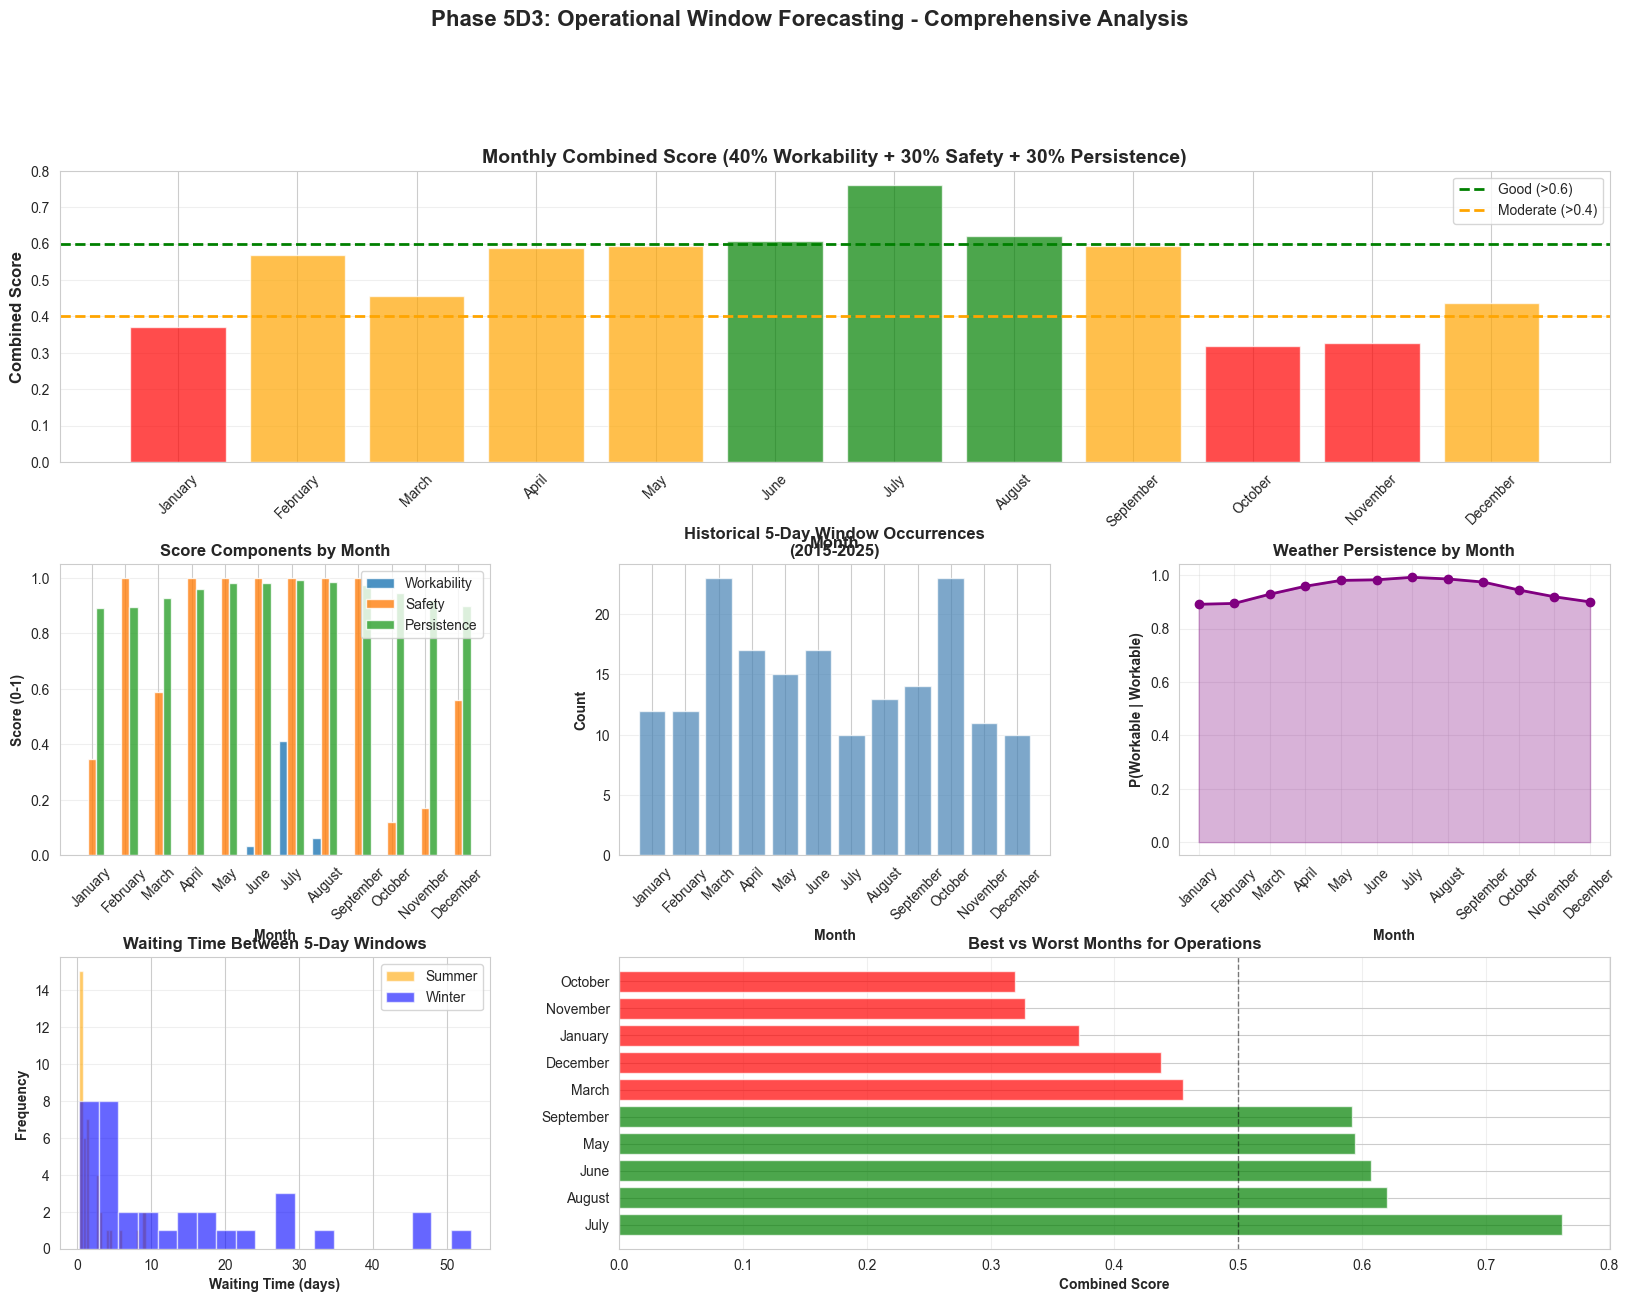

In [7]:
# Cell 7: Comprehensive Visualizations

os.makedirs('../data/processed/phase5d3', exist_ok=True)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# Plot 1: Combined Score by Month
ax1 = fig.add_subplot(gs[0, :])
colors = ['green' if s > 0.6 else 'orange' if s > 0.4 else 'red' for s in df_combined['Combined_Score']]
ax1.bar(df_combined['Month'], df_combined['Combined_Score'], color=colors, alpha=0.7)
ax1.axhline(0.6, color='green', linestyle='--', linewidth=2, label='Good (>0.6)')
ax1.axhline(0.4, color='orange', linestyle='--', linewidth=2, label='Moderate (>0.4)')
ax1.set_xlabel('Month', fontweight='bold', fontsize=12)
ax1.set_ylabel('Combined Score', fontweight='bold', fontsize=12)
ax1.set_title('Monthly Combined Score (40% Workability + 30% Safety + 30% Persistence)', 
              fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Score Components Breakdown
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(12)
width = 0.25
ax2.bar(x - width, df_combined['Workability_5d'], width, label='Workability', alpha=0.8)
ax2.bar(x, df_combined['Safety_30d'], width, label='Safety', alpha=0.8)
ax2.bar(x + width, df_combined['Persistence'], width, label='Persistence', alpha=0.8)
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Score (0-1)', fontweight='bold')
ax2.set_title('Score Components by Month', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_combined['Month'], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Historical 5-day Windows
ax3 = fig.add_subplot(gs[1, 1])
ax3.bar(df_combined['Month'], df_combined['Historical_Windows'], color='steelblue', alpha=0.7)
ax3.set_xlabel('Month', fontweight='bold')
ax3.set_ylabel('Count', fontweight='bold')
ax3.set_title('Historical 5-Day Window Occurrences\n(2015-2025)', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Persistence by Month
ax4 = fig.add_subplot(gs[1, 2])
ax4.plot(df_persistence['Month'], df_persistence['P(Work|Work)'], marker='o', linewidth=2, color='purple')
ax4.fill_between(range(12), df_persistence['P(Work|Work)'], alpha=0.3, color='purple')
ax4.set_xlabel('Month', fontweight='bold')
ax4.set_ylabel('P(Workable | Workable)', fontweight='bold')
ax4.set_title('Weather Persistence by Month', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# Plot 5: Waiting Time Distribution (Summer vs Winter)
ax5 = fig.add_subplot(gs[2, 0])
summer_waits = []
winter_waits = []
for month, waits in monthly_waiting.items():
    if month in [6, 7, 8]:  # Summer
        summer_waits.extend(waits)
    elif month in [12, 1, 2]:  # Winter
        winter_waits.extend(waits)

if len(summer_waits) > 0:
    ax5.hist(summer_waits, bins=20, alpha=0.6, label='Summer', color='orange')
if len(winter_waits) > 0:
    ax5.hist(winter_waits, bins=20, alpha=0.6, label='Winter', color='blue')
ax5.set_xlabel('Waiting Time (days)', fontweight='bold')
ax5.set_ylabel('Frequency', fontweight='bold')
ax5.set_title('Waiting Time Between 5-Day Windows', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Top 5 vs Bottom 5 Months
ax6 = fig.add_subplot(gs[2, 1:])
top5 = df_combined_sorted.head(5)
bottom5 = df_combined_sorted.tail(5)

y_pos = np.arange(10)
scores = list(top5['Combined_Score']) + list(bottom5['Combined_Score'])
labels = list(top5['Month']) + list(bottom5['Month'])
colors_bar = ['green']*5 + ['red']*5

ax6.barh(y_pos, scores, color=colors_bar, alpha=0.7)
ax6.set_yticks(y_pos)
ax6.set_yticklabels(labels)
ax6.set_xlabel('Combined Score', fontweight='bold')
ax6.set_title('Best vs Worst Months for Operations', fontsize=12, fontweight='bold')
ax6.axvline(0.5, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax6.grid(True, alpha=0.3, axis='x')

plt.suptitle('Phase 5D3: Operational Window Forecasting - Comprehensive Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('../data/processed/phase5d3/operational_window_forecast.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved operational_window_forecast.png")
plt.show()

## PART 7: SAVE RESULTS

In [8]:
# Cell 8: Save Results

results = {
    'combined_scores': df_combined,
    'persistence': df_persistence,
    'waiting_times': df_waiting,
    'historical_windows': historical_windows,
    'operation_limits': OPERATION_LIMITS
}

with open('../data/processed/phase5d3/operational_forecast_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save CSVs
df_combined.to_csv('../data/processed/phase5d3/combined_scores.csv', index=False)
df_persistence.to_csv('../data/processed/phase5d3/persistence_matrix.csv', index=False)
df_waiting.to_csv('../data/processed/phase5d3/waiting_times.csv', index=False)

print("\n✅ Results saved to: data/processed/phase5d3/")


✅ Results saved to: data/processed/phase5d3/


## PART 8: FINAL RECOMMENDATIONS

In [9]:
# Cell 9: Generate Final Recommendations

print("\n" + "="*80)
print("PHASE 5D3 COMPLETE: OPERATIONAL WINDOW FORECASTING")
print("="*80)

print("\n1. OPTIMAL SCHEDULING MONTHS (Combined Score > 0.6):")
optimal_months = df_combined[df_combined['Combined_Score'] > 0.6].sort_values('Combined_Score', ascending=False)
if len(optimal_months) > 0:
    for idx, row in optimal_months.iterrows():
        print(f"   {row['Month']}: Score={row['Combined_Score']:.3f}, {row['Historical_Windows']} historical 5-day windows")
else:
    print("   None (no months exceed 0.6 threshold)")

print("\n2. MONTHS TO AVOID (Combined Score < 0.4):")
avoid_months = df_combined[df_combined['Combined_Score'] < 0.4].sort_values('Combined_Score')
if len(avoid_months) > 0:
    for idx, row in avoid_months.iterrows():
        print(f"   {row['Month']}: Score={row['Combined_Score']:.3f}")
else:
    print("   None (all months above 0.4)")

print("\n3. WEATHER PERSISTENCE INSIGHTS:")
high_persist = df_persistence[df_persistence['P(Work|Work)'] > 0.95]
if len(high_persist) > 0:
    print(f"   High persistence months (>0.95): {', '.join(high_persist['Month'].tolist())}")
    print("   → Once workable, very likely to stay workable")
low_persist = df_persistence[df_persistence['P(Work|Work)'] < 0.80]
if len(low_persist) > 0:
    print(f"   Low persistence months (<0.80): {', '.join(low_persist['Month'].tolist())}")
    print("   → Rapidly changing conditions, harder to plan")

print("\n4. EXPECTED WAITING TIMES (5-Day Windows):")
best_wait = df_waiting[df_waiting['Mean_Days'] == df_waiting['Mean_Days'].min()].iloc[0]
worst_wait = df_waiting[df_waiting['Mean_Days'] == df_waiting['Mean_Days'].max()].iloc[0]
print(f"   Shortest: {best_wait['Month']} ({best_wait['Mean_Days']:.1f} days between windows)")
print(f"   Longest: {worst_wait['Month']} ({worst_wait['Mean_Days']:.1f} days between windows)")

print("\n5. INTEGRATED PHASE 5D RECOMMENDATIONS:")
print("   Phase 5D1: Weather window probabilities ✅")
print("   Phase 5D2: Extreme event risk ✅")
print("   Phase 5D3: Combined forecasting ✅")
print("\n   🎯 FINAL RECOMMENDATION:")
top_month = df_combined_sorted.iloc[0]
print(f"\n   Best Month: {top_month['Month']}")
print(f"   - Combined Score: {top_month['Combined_Score']:.3f}")
print(f"   - 5-day workability: {top_month['Workability_5d']*100:.1f}%")
print(f"   - 30-day safety: {top_month['Safety_30d']*100:.1f}% (no extreme events)")
print(f"   - Persistence: {top_month['Persistence']:.3f}")
print(f"   - Historical windows: {top_month['Historical_Windows']} occurrences in 10 years")

# Calculate expected window per year
expected_per_year = top_month['Historical_Windows'] / 10
print(f"   - Expected: ~{expected_per_year:.1f} favorable 5-day windows per year")

print("\n" + "="*80)
print("⚠️  LOCATION-SPECIFIC ANALYSIS: UK Northeast Coast (2015-2025)")
print("⚠️  Re-analysis required for different locations!")
print("="*80)

print("\n" + "="*80)
print("✅ Phase 5D Complete! Ready for Phase 5E: Integrated Dashboard")
print("="*80)


PHASE 5D3 COMPLETE: OPERATIONAL WINDOW FORECASTING

1. OPTIMAL SCHEDULING MONTHS (Combined Score > 0.6):
   July: Score=0.762, 10 historical 5-day windows
   August: Score=0.620, 13 historical 5-day windows
   June: Score=0.608, 17 historical 5-day windows

2. MONTHS TO AVOID (Combined Score < 0.4):
   October: Score=0.319
   November: Score=0.327
   January: Score=0.372

3. WEATHER PERSISTENCE INSIGHTS:
   High persistence months (>0.95): April, May, June, July, August, September
   → Once workable, very likely to stay workable

4. EXPECTED WAITING TIMES (5-Day Windows):
   Shortest: June (1.0 days between windows)
   Longest: November (24.3 days between windows)

5. INTEGRATED PHASE 5D RECOMMENDATIONS:
   Phase 5D1: Weather window probabilities ✅
   Phase 5D2: Extreme event risk ✅
   Phase 5D3: Combined forecasting ✅

   🎯 FINAL RECOMMENDATION:

   Best Month: July
   - Combined Score: 0.762
   - 5-day workability: 41.2%
   - 30-day safety: 100.0% (no extreme events)
   - Persistenc